In [1]:
from ultralytics import YOLO
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

**Approach explanation**
First I tried to train the YOLO model on the benchmark dataset MPIIGaze, but the results of the training were mostly overfitted. Besides it took me long and engines with more capacities were needed. With the right amount of dataset for training, there is a possibility to accurately predict the gaze of the person. However, according to the small research I made, specifically gaze trained models based on CNN models (MPIIFaceGaze, Gaze360,RT-GENE, etc.) perform in average better that YOLO (extensive review of these models were done by https://phi-ai.buaa.edu.cn/Gazehub/3D-method/). The reason is that Yolo initially was trained to detect more general objects like cars, houses, etc.

As a result, I decided to use multi-stage approach and detect the head pose with the help of the pretrained Yolo model (https://github.com/AbelKidaneHaile/Reports) and gaze with the help of pretrained GAZE-LLE model.

Pretrained YOLO model is optimized for detecting human heads, making it particularly suitable for applications like gaze estimation where precise head localization is crucial. 

In [2]:
# === STEP 1: Load Models ===

# Load YOLOv8 custom-trained head detector
head_detector = YOLO("custom_head_yolov8n.pt")

I selected the __Gaze-LLE model (Gaze Estimation via Large-scale Learned Encoders)__ because it represents a cutting-edge approach in appearance-based gaze prediction. Unlike traditional methods that rely on hand-crafted features or person-specific calibration, Gaze-LLE leverages a frozen DINOv2 vision transformer backbone to extract rich, context-aware representations from full-scene images. It uses a lightweight gaze decoder conditioned on detected head bounding boxes, enabling accurate zero-shot or few-shot gaze estimation across varied scenes and individuals. This makes it particularly well-suited for applications where robustness, generalization, and minimal calibration are crucial. Furthermore, its accessibility via PyTorch Hub and open weights facilitates rapid integration into modular pipelines like mine, where head detection from YOLO feeds directly into Gaze-LLE's decoder. https://github.com/fkryan/gazelle 

In [3]:
# Load Gaze-LLE model and transform
from torch.hub import load

# Only load once to reuse later
gaze_model, gaze_transform = load('fkryan/gazelle', 'gazelle_dinov2_vitb14')
gaze_model.eval()

Using cache found in C:\Users\User/.cache\torch\hub\fkryan_gazelle_main
c:\Users\User\.conda\envs\deepl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\User/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias

In [4]:
# === STEP 2: Detect Heads ===
from PIL import Image

def detect_heads(image_path):
    results = head_detector(image_path)
    boxes = []
    result = results[0]
    for box in result.boxes:
        if int(box.cls[0]) == 0:  # Assuming 0 is head
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            boxes.append((x1, y1, x2, y2))
    return boxes

In [5]:
# === STEP 3: Run Gaze-LLE on Detected Heads ===
def run_gaze_lle(image, head_bboxes):
    width, height = image.size
    input_tensor = gaze_transform(image).unsqueeze(0)

    norm_bboxes = [
        (x1 / width, y1 / height, x2 / width, y2 / height)
        for (x1, y1, x2, y2) in head_bboxes
    ]

    if not norm_bboxes:
        return []

    input_data = {
        'images': input_tensor,
        'bboxes': [norm_bboxes]
    }

    with torch.no_grad():
        output = gaze_model(input_data)

    return output['heatmap'][0]  # shape: [num_heads, H, W]


In [6]:
# === STEP 4: Draw Bounding Boxes and Gaze Arrows ===

def draw_gaze(image, head_bboxes, heatmaps):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for (x1, y1, x2, y2), heatmap in zip(head_bboxes, heatmaps):
        head_center = ((x1 + x2) / 2, (y1 + y2) / 2)

        # Gaze target
        heatmap_np = heatmap.detach().cpu().numpy()
        y, x = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
        gaze_x = x * width / heatmap_np.shape[1]
        gaze_y = y * height / heatmap_np.shape[0]

        gaze_target = (gaze_x, gaze_y)

        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.line([head_center, gaze_target], fill="blue", width=3)
        draw.ellipse((gaze_x - 4, gaze_y - 4, gaze_x + 4, gaze_y + 4), fill="blue")

    return image

In [7]:
# === STEP 5: Process a Folder of Images ===
import os

def process_folder(folder_path):
    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        full_path = os.path.join(folder_path, filename)
        image = Image.open(full_path).convert("RGB")

        head_bboxes = detect_heads(full_path)
        if not head_bboxes:
            print(f"No heads detected in {filename}")
            continue

        heatmaps = run_gaze_lle(image, head_bboxes)
        image_out = draw_gaze(image, head_bboxes, heatmaps)

        plt.figure(figsize=(8, 6))
        plt.imshow(image_out)
        plt.axis("off")
        plt.title(filename)
        plt.show()



image 1/1 D:\Experimentation\folder_with images\test_image.jpg: 864x1280 3 heads, 4994.6ms
Speed: 42.6ms preprocess, 4994.6ms inference, 38.0ms postprocess per image at shape (1, 3, 864, 1280)


c:\Users\User\.conda\envs\deepl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


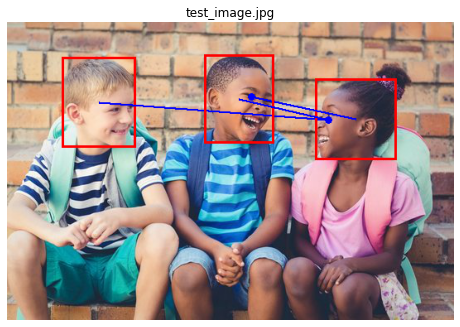


image 1/1 D:\Experimentation\folder_with images\test_image2.jpg: 864x1280 1 head, 4703.2ms
Speed: 16.5ms preprocess, 4703.2ms inference, 1.9ms postprocess per image at shape (1, 3, 864, 1280)


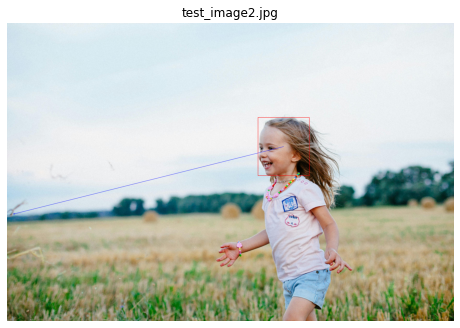


image 1/1 D:\Experimentation\folder_with images\test_image3.jpg: 1280x768 1 head, 4145.8ms
Speed: 10.9ms preprocess, 4145.8ms inference, 5.8ms postprocess per image at shape (1, 3, 1280, 768)


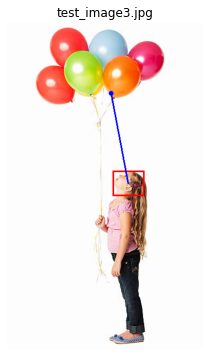

In [8]:
# Example usage:
process_folder("D:/Experimentation/folder_with images")